In [1]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML
display(HTML("<style>.container { width:50% !important; }</style>"))

In [144]:
# Import the necessary modules
from skllm.datasets import get_classification_dataset
from skllm.config import SKLLMConfig
from skllm.models.gpt.classification.zero_shot import ZeroShotGPTClassifier

sk = 'Your Secret Key'


# Configure the credentials
SKLLMConfig.set_openai_key(sk)
SKLLMConfig.set_openai_org("Your Org")

In [145]:
# Initialize the model and make the predictions
#clf = ZeroShotGPTClassifier(model="gpt-4")
TEMPLATE = """
You are a financial/economic analyst provided with the following information:
1. An snippet of text. The sample is delimited with triple backticks.
2. A list containing labels that for whether the snippet is bearish or bullish for the economy.
The list is delimited with square brackets. The values in the list are enclosed in the single quotes and comma separated.

Perform the following tasks:
1. Identify to which value from the list the provided document belongs.
3. Assign the provided document to that value.
4. Provide your response in a JSON format containing a single key `label` and a value corresponding to the assigned value. Do not provide any additional information except the JSON.

List of categories: {labels}

Text sample: ```{x}```

Your JSON response:
"""

clf = ZeroShotGPTClassifier(model="gpt-4-turbo-preview", prompt_template = TEMPLATE)

In [146]:
data = pd.read_csv("economy.csv", index_col = 0, parse_dates = True).sort_index()

In [147]:
X = data.Text.values

In [148]:
X = data.values
clf.fit(None,['Very Bullish', 'Somewhat Bullish', 'Neutral', 'Somewhat Bearish', 'Very Bearish'])
labels = clf.predict(X)

100%|█████████████████████████████████████████| 647/647 [17:30<00:00,  1.62s/it]


In [149]:
data.index = pd.to_datetime(data.index.date, format='mixed')
data['sentiment'] = labels

In [379]:
data[data.sentiment =='Neutral']

,Text,section,News_desk,sentiment
1985-01-03,FIRST PORTRAIT OF THE VERY OLD: NOT SO FRAIL T...,Home & Garden,Home Desk,Neutral
1985-01-09,TRADING JOBS AT THE TOP: DONALD THOMAS REGAN D...,U.S.,National Desk,Neutral
1985-01-10,MOSCOW PORTRAYS TALKS AS SUCCESS The Soviet pr...,World,Foreign Desk,Neutral
1985-01-10,UNEMPLOYMENT RISES SLIGHTLY DESPITE CREATION O...,U.S.,National Desk,Neutral
1985-01-15,ISRAEL ANNOUNCES THREE-STAGE PLAN TO LEAVE LEB...,World,Foreign Desk,Neutral
...,...,...,...,...
2024-02-02,Could a Giant Parasol in Outer Space Help Solv...,Climate,Climate,Neutral
2024-02-05,Zelensky Hints at Major Shake-Up of Ukraine’s ...,World,Foreign,Neutral
2024-02-09,"For Voters, When Does Old Become Too Old? When...",The Upshot,Upshot,Neutral
2024-02-16,"In Prison or Out, Navalny Was the Thorn in Put...",World,Foreign,Neutral


In [383]:
data[data.sentiment.isin(['Very Bullish'])]

,Text,section,News_desk,sentiment
1985-01-01,"GAIN OF 72,000 JOBS FOR NEW YORK CITY IN '84 S...",New York,Metropolitan Desk,Very Bullish
1985-01-23,"ECONOMIC GROWTH UP 6.8% LAST YEAR, BEST GAIN S...",Business Day,Financial Desk,Very Bullish
1991-12-21,FED CUTS KEY RATE IT CHARGES BANKS TO A 27-YEA...,Business Day,Financial Desk,Very Bullish
1996-11-06,"Economy Helps Again Four years ago, a falterin...",U.S.,National Desk,Very Bullish
1997-12-06,WAGES ALSO CLIMB The American economy showed s...,Business Day,Business/Financial Desk,Very Bullish
1999-12-01,Gore Trumpets Economy Al Gore said prosperity ...,U.S.,National Desk,Very Bullish
1999-12-04,"234,000 NEW JOBS IN NOVEMBER KEPT ECONOMY HUMM...",Business Day,Business/Financial Desk,Very Bullish
2018-10-26,U.S. Economy Charged Ahead in the Third Quarte...,Business Day,Business,Very Bullish
2019-05-03,Job Growth Underscores Economy’s Vigor; Unempl...,Business Day,Business,Very Bullish
2020-03-15,Fed Slashes Rates to Near-Zero and Unveils Swe...,Business Day,Business,Very Bullish


In [171]:
subset = data.copy()

In [304]:
subset2 = subset[((subset['sentiment'] == 'Somewhat Bullish') | (subset['sentiment'] == 'Very Bullish')) & (subset.index.year >= 2008)]

In [305]:
import yfinance as yf

In [308]:
asset = "^GSPC"
asset = yf.download(asset)[["Open"]].copy().shift(-1)
asset['date'] = asset.index
asset['Returns'] = np.log(asset.Open).diff().dropna()

[*********************100%%**********************]  1 of 1 completed
/Users/nathankunz/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [309]:
asset_ss = asset[asset.index >=  '2008-01-01'].copy()

In [310]:
subset3 = subset2.sentiment

In [322]:
asset_ss['signal'] = 1
profs = []
h = 4
for j in range(len(subset3.index)):
    asset_ss.loc[asset_ss.index[asset_ss.index >= subset3.index[j]][:h], 'signal'] = -1

asset_ss = asset_ss.fillna(0)
asset_ss['strat_returns'] = asset_ss['signal'].shift() * asset_ss['Returns']
asset_ss['C_returns'] = np.exp(asset_ss['strat_returns'].cumsum()) - 1
asset_ss['C_returns2'] = np.exp(asset_ss['Returns'].cumsum()) - 1

In [323]:
import matplotlib.pyplot as plt

In [324]:
asset_ss

,Open,date,Returns,signal,strat_returns,C_returns,C_returns2
Date,,,,,,,
2008-01-02,1447.550049,2008-01-02,-0.014008,1,NaN,NaN,-0.013910
2008-01-03,1444.010010,2008-01-03,-0.002449,1,-0.002449,-0.002446,-0.016322
2008-01-04,1414.069946,2008-01-04,-0.020952,1,-0.020952,-0.023129,-0.036717
2008-01-07,1415.709961,2008-01-07,0.001159,1,0.001159,-0.021996,-0.035600
2008-01-08,1390.250000,2008-01-08,-0.018148,1,-0.018148,-0.039584,-0.052944
...,...,...,...,...,...,...,...
2024-02-20,4963.029785,2024-02-20,-0.005283,1,-0.005283,5.083421,2.380880
2024-02-21,5038.830078,2024-02-21,0.015158,1,0.015158,5.176333,2.432516
2024-02-22,5100.919922,2024-02-22,0.012247,1,0.012247,5.252440,2.474812


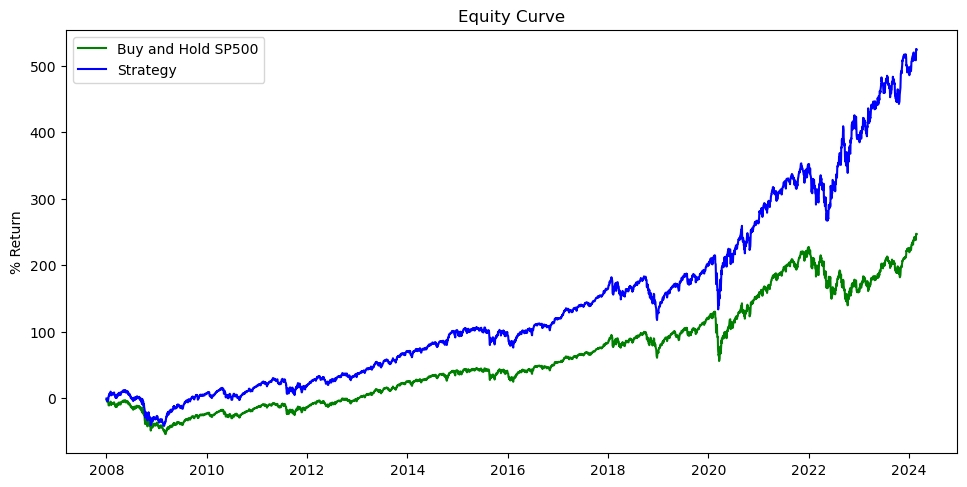

In [335]:
plt.figure(figsize = (11.5,5.5))
plt.title('Equity Curve')
plt.plot(asset_ss['C_returns2']*100, label = 'Buy and Hold SP500', color = 'green')
plt.plot(asset_ss['C_returns']*100, label = 'Strategy',  color = 'Blue')
plt.ylabel('% Return')
plt.legend()

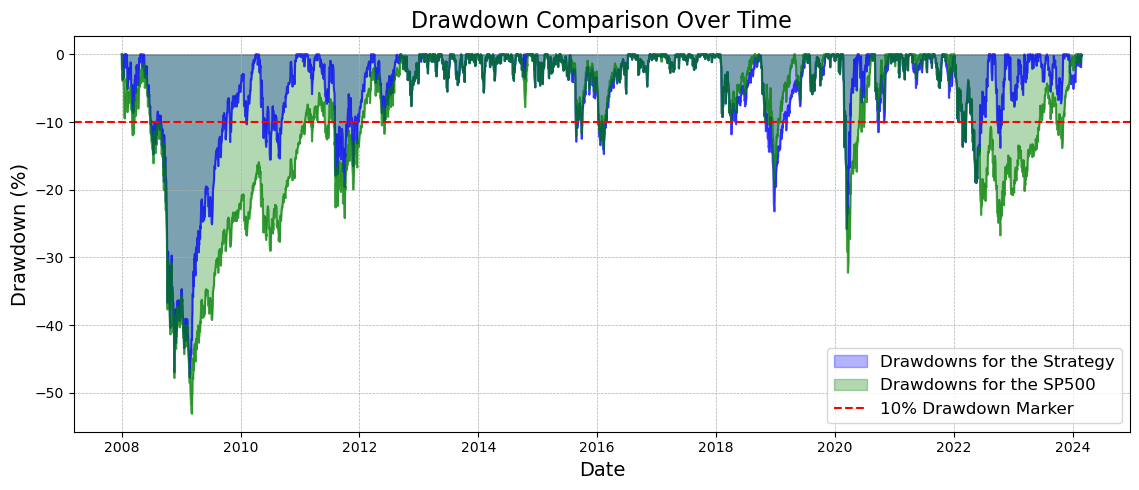

In [375]:
# Step 1: Calculate the running maximum
running_max1 = asset_ss['C_returns'].cummax()
running_max2 = asset_ss['C_returns2'].cummax()

# Step 2: Calculate the drawdowns
drawdown1 = ((asset_ss['C_returns']/running_max1) -1)*100 # Convert to percentage
drawdown2 = ((asset_ss['C_returns2']/running_max2) -1)*100  # Convert to percentage

# Step 3: Visualize the drawdowns with improved aesthetics
plt.figure(figsize=(11.5, 5))

# Using fill_between for a nicer visual effect
plt.fill_between(asset_ss.index, drawdown1, alpha=0.3, color='blue', label='Drawdowns for the Strategy')
plt.fill_between(asset_ss.index, drawdown2, alpha=0.3, color='green', label='Drawdowns for the SP500')

plt.plot(asset_ss.index, drawdown1, color='blue', alpha=0.7)  # Make line more visible
plt.plot(asset_ss.index, drawdown2, color='green', alpha=0.7)  # Make line more visible

plt.axhline(-10, linestyle='--', color='red', label='10% Drawdown Marker')

# Enhance the plot
plt.title('Drawdown Comparison Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Drawdown (%)', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)


plt.tight_layout()
plt.show()